## K-means

给中国省会建立能源中心

In [2]:
from pylab import mpl
import re
import math
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import defaultdict
import numpy as np

In [3]:
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像负号'-'显示为方块的问题

In [4]:
coordination_source = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

In [5]:
city_location = {
    '香港': (114.17, 22.28)
}

In [6]:
test_string = "{name:'兰州', geoCoord:[103.73, 36.03]},"
pattern = re.compile(r"name:'(\w+)',\s+geoCoord:\[(\d+.\d+),\s(\d+.\d+)\]")

In [ ]:
for line in coordination_source.split('\n'):
    city_info = pattern.findall(line)
    if not city_info: continue
    
    # following: we find the city info
    
    city, long, lat = city_info[0]
    
    long, lat = float(long), float(lat)
    
    city_location[city] = (long, lat)

In [11]:
city_location

{'香港': (114.17, 22.28),
 '兰州': (103.73, 36.03),
 '嘉峪关': (98.17, 39.47),
 '西宁': (101.74, 36.56),
 '成都': (104.06, 30.67),
 '石家庄': (114.48, 38.03),
 '拉萨': (102.73, 25.04),
 '贵阳': (106.71, 26.57),
 '武汉': (114.31, 30.52),
 '郑州': (113.65, 34.76),
 '济南': (117.0, 36.65),
 '南京': (118.78, 32.04),
 '合肥': (117.27, 31.86),
 '杭州': (120.19, 30.26),
 '南昌': (115.89, 28.68),
 '福州': (119.3, 26.08),
 '广州': (113.23, 23.16),
 '长沙': (113.0, 28.21),
 '海口': (110.35, 20.02),
 '沈阳': (123.38, 41.8),
 '长春': (125.35, 43.88),
 '哈尔滨': (126.63, 45.75),
 '太原': (112.53, 37.87),
 '西安': (108.95, 34.27),
 '台湾': (121.3, 25.03),
 '北京': (116.46, 39.92),
 '上海': (121.48, 31.22),
 '重庆': (106.54, 29.59),
 '天津': (117.2, 39.13),
 '呼和浩特': (111.65, 40.82),
 '南宁': (108.33, 22.84),
 '西藏': (91.11, 29.97),
 '银川': (106.27, 38.47),
 '乌鲁木齐': (87.68, 43.77),
 '澳门': (113.54, 22.19)}

In [12]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

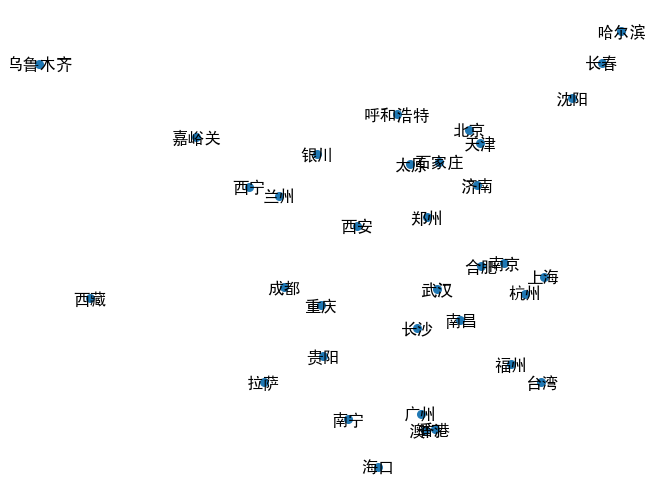

In [18]:
%matplotlib inline

city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_location.keys()))
nx.draw(city_graph, city_location, with_labels=True, node_size=30)

## K-means: Initial k random centers

In [23]:
k = 10

all_x = []
all_y = []

for _, location in city_location.items():
    x, y = location
    all_x.append(x)
    all_y.append(y)

In [24]:
def get_random_center(all_x, all_y):
    r_x = random.uniform(min(all_x), max(all_x))
    r_y = random.uniform(min(all_y), max(all_y))
    
    return r_x, r_y

get_random_center(all_x, all_y)

K = 5
centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}

In [26]:
closet_points = defaultdict(list)

for x, y, in zip(all_x, all_y):
    closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
    
    closet_points[closet_c].append([x, y])

In [28]:
def iterate_once(centers, closet_points, threshold=5):
    have_changed = False
    
    for c in closet_points:
        former_center = centers[c]

        neighbors = closet_points[c]

        neighbors_center = np.mean(neighbors, axis=0)

        if geo_distance(neighbors_center, former_center) > threshold:
            centers[c] = neighbors_center
            have_changed = True
        else:
            pass ## keep former center
        
    return centers, have_changed

In [29]:
def kmeans(Xs, k, threshold=5):
    all_x = Xs[:, 0]
    all_y = Xs[:, 1]
    
    K = k
    
    centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}
    
    changed = True
    
    while changed:
        closet_points = defaultdict(list)

        for x, y, in zip(all_x, all_y):
            closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])    
            closet_points[closet_c].append([x, y])   
            
        centers, changed = iterate_once(centers, closet_points, threshold)
        print('iteration')

    return centers

In [33]:
kmeans(np.array(list(city_location.values())), k=5, threshold=5)

iteration
iteration
iteration
iteration
iteration
iteration


{'1': array([117.02545455,  39.35272727]),
 '2': array([91.11, 29.97]),
 '3': array([118.565  ,  29.46125]),
 '4': array([99.518, 38.86 ]),
 '5': array([109.266,  25.057])}

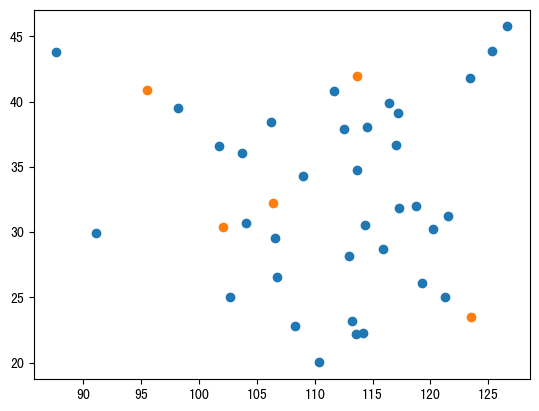

In [34]:
plt.scatter(all_x, all_y)
plt.scatter(*zip(*centers.values()))

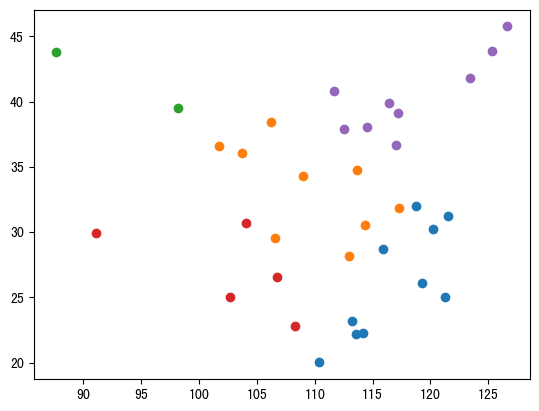

In [35]:
for c, points in closet_points.items():
    plt.scatter(*zip(*points))

In [36]:
city_location_with_station = {
    '能源站-{}'.format(i): position for i, position in centers.items()
}
city_location_with_station


{'能源站-1': (95.5043990432184, 40.90313240492959),
 '能源站-2': (106.38393509323726, 32.26385737182164),
 '能源站-3': (123.47578976574059, 23.468059892785988),
 '能源站-4': (113.69277090527862, 41.95114416114835),
 '能源站-5': (102.09706315556798, 30.42347985879278)}

In [37]:
def draw_cities(citise, color=None):
    city_graph = nx.Graph()
    city_graph.add_nodes_from(list(citise.keys()))
    nx.draw(city_graph, citise, node_color=color, with_labels=True, node_size=30)

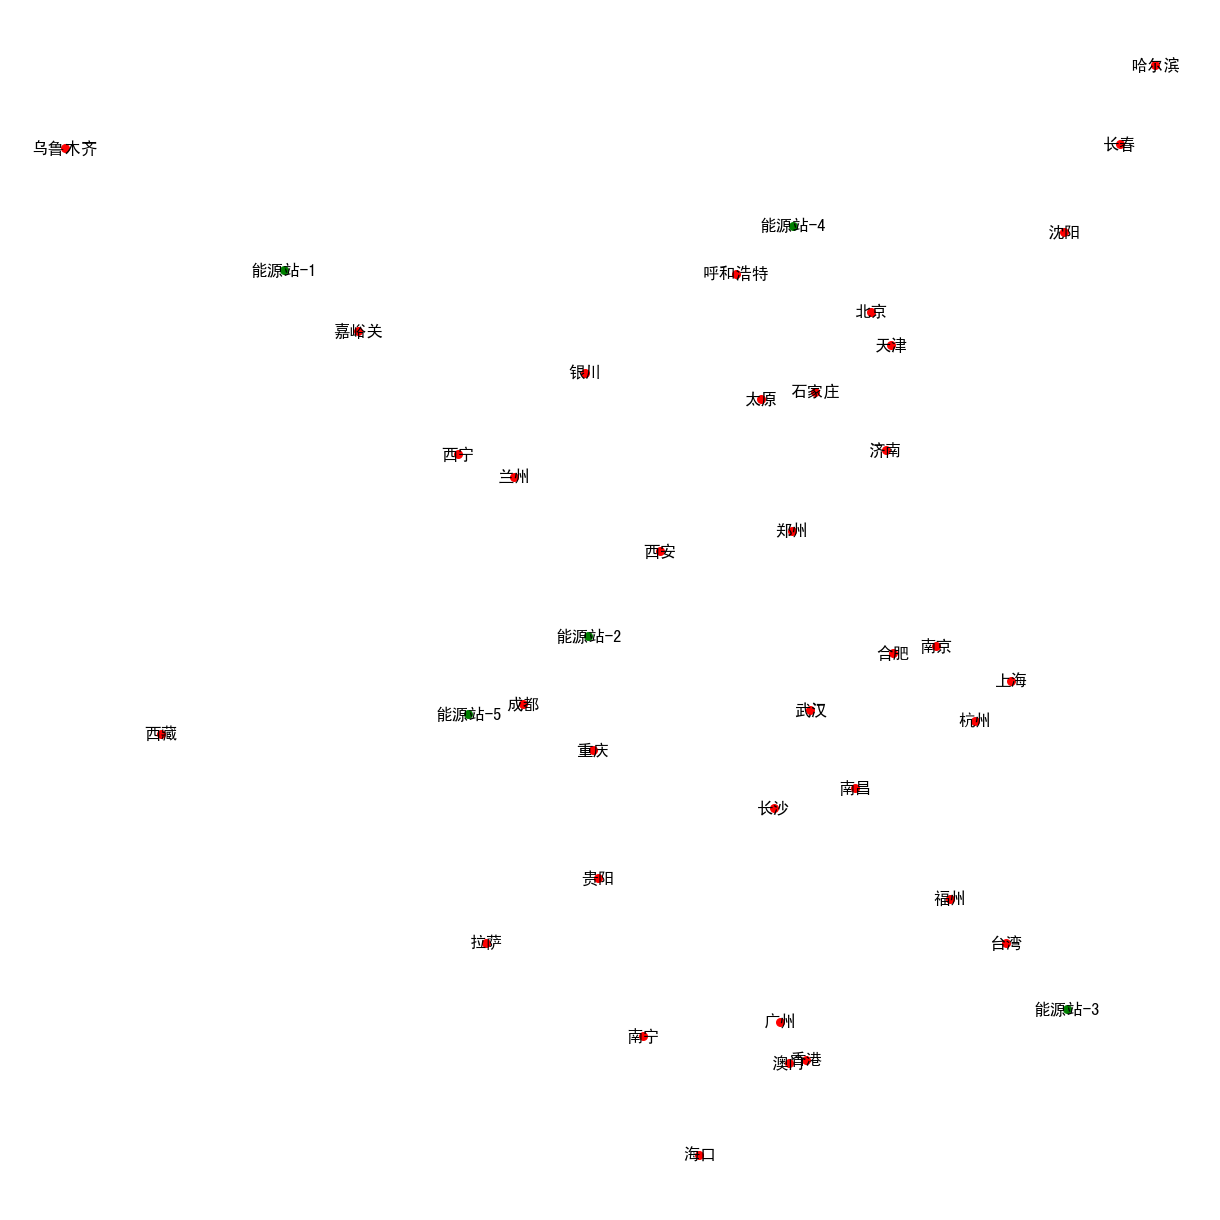

In [38]:
%matplotlib inline

plt.figure(1,figsize=(12,12)) 
draw_cities(city_location_with_station, color='green')
draw_cities(city_location, color='red')

![欢迎订阅：坍缩的奇点](../assets/Capture-2023-11-02-164446.png)